 #  <center>Mercedes Benz Greener Manufacturing 
<center> Johannes Rist </center>
    
<center> Version 1, 20.09.2020 </center>

Anhand dieses prototypenhaften Aufbaus wird die Implementierung eines neuronalen Netzes für eine Problemstellung aus der Produktionsumgebung dargelegt. 
Viele Firmen (darunter auch die MTU Friedrichshafen) erheben mittlerweile viele Daten in der Produktion. Ziel der Datenaufnahme ist dabei häufig die Dokumentation des Produktionsprozesses. Diese Datensätze weisen zwar viele Produktionsparameter auf, jedoch fehlt meist ein Bezug zu einer Zielvariablen, sodass die Voraussetzung für das Training eines neuronalen Netzes nicht gegeben ist. Aufgrund dessen sind die meisten Datensätze für Data-Science Zwecke ungeeignet. Für das folgende Beispiel wird deshalb ein frei zugänglicher anonymisierter Datensatz aus dem Internet verwendet.

Zunächst wird Keras, das Framework zur Modellierung neuronaler Netze und Pandas, eine Programmbibliothek zur Datenverwaltung eingelesen.

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
import pandas as pd

Anschließend wird der Datensatz importiert und angezeigt.

In [3]:
DataPath=r"C:\Users\johan\Desktop\MercedesBenzGreenerManufacturing\data.csv"
data = pd.read_csv(DataPath, delimiter=',')
data

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


 # 1. Geschäftsprozessverständnis
Der Mercedes-Benz-Greener-Manufacturing-Datensatz enthält anonymisierte Produktionsdaten der Firma Mercedes Benz und entstammt der Website Kaggle.io, einer Plattform für Data Science Competitions. Dort werden die Teilnehmer dazu aufgefordert, anhand von Permutationen von Mercedes-Benz-Fahrzeugmerkmalen vorauszusagen, wie lange das jeweilige Fahrzeug auf dem Prüfstand benötigen wird, um die Prüfung zu bestehen. Die von den Teilnehmern erzeugten Modelle sollen zu einer schnelleren Prüfung beitragen und somit helfen geringere Kohlenstoffdioxidemissionen zu erzeugen, ohne die Standards von Mercedes Benz zu reduzieren. Da in der Beschreibung des Use Cases auf Kaggle nicht angegeben ist, anhand welcher Kriterien Mercedes Benz derzeit die geplante Prüfdauer pro Fahrzeug festlegt, wird für dieses Beispiel davon ausgegangen, dass hierfür der Mittelwert aller Prüfzeiten verwendet wird. Ziel der Implementierung des neuronalen Netzes ist es also, Voraussagen anhand der Fahrzeugmerkmale zu treffen, die genauer sind als die einfache Anwendung des Mittelwerts aller Prüfzeiten. Als Metrik soll der Mean Absolute Error (MAE) verwendet werden.  

Zur Berechnung des MAE unter Verwendung des Mittelwerts über alle Prüfzeiten, wird zunächst die Prüfzeit aus dem Datensatz extrahiert und im Dataframe Y abgelegt.

In [4]:
y=pd.DataFrame(data.y)
y

,y
0,130.81
1,88.53
2,76.26
3,80.62
4,78.02
...,...
4204,107.39
4205,108.77
4206,109.22
4207,87.48


Anschließend wird der Mittelwert aller Prüfzeiten berechnet und der Variablen y_mean zugewiesen.

In [5]:
y_mean=y.mean()
y_mean

y    100.669318
dtype: float64

Danach wird der Mittelwert von jedem Wert im Dataframe y subtrahiert und im Dataframe y_err abgelegt.

In [6]:
y_err=y-y_mean
y_err

,y
0,30.140682
1,-12.139318
2,-24.409318
3,-20.049318
4,-22.649318
...,...
4204,6.720682
4205,8.100682
4206,8.550682
4207,-13.189318


Die Anwendung der Funktion abs() auf das Dataframe y_err bildet von allen Werten den Absolutwert und legt diesen im Dataframe der Variable y_err_abs ab.

In [7]:
y_err_abs=abs(y_err)
y_err_abs

,y
0,30.140682
1,12.139318
2,24.409318
3,20.049318
4,22.649318
...,...
4204,6.720682
4205,8.100682
4206,8.550682
4207,13.189318


Durch Anwenden der mean()-Funktion auf das Dataframe y_err_abs wird der initiale Mean Absolute Error berechnet, für den Fall, dass für jedes Fahrzeug der Mittelwert als geplante Prüfzeit angenommen wird. Dieser MAE wird der Variablen MAE_initial zugewiesen.

In [8]:
MAE_initial=y_err_abs.mean()
MAE_initial

y    10.088697
dtype: float64

# 2. Datenverständnis

## Prüfung auf NA- und NULL-Werte
Die Funktion isnull() zählt NA/NULL-Werte und gibt für jeden Wert ein True oder False aus. Durch anschließende Anwendung der Funktion sum() werden diese für jede Zeile aufsummiert und in die Variable NaN geschrieben. Ein weiteres Anwenden der Funktion sum() auf die Variable NaN summiert die Werte der darin enthaltenen Liste auf. Enthält der Datensatz keine NA- oder NULL-Werte muss das Ergebnis 0 lauten.

In [9]:
NaN=data.isnull().sum()
NaN

ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64

In [10]:
NaN.sum()


0

## Datentypen
Vor der Betrachtung der Datentypen wird zunächst die Spalte y, die die Zielwerte enthält, in die Variable labels kopiert. Diese wird anschließend gemeinsam mit der Spalte 'ID', von der keine Informationen bezüglich der Prüfdauer zu erwarten sind, aus dem DataFrame data entfernt.

In [11]:
labels=data['y']
data=data.drop(columns=['y','ID'])
data

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,k,v,at,a,d,u,j,o,0,0,...,0,0,1,0,0,0,0,0,0,0
1,k,t,av,e,d,y,l,o,0,0,...,1,0,0,0,0,0,0,0,0,0
2,az,w,n,c,d,x,j,x,0,0,...,0,0,0,0,0,0,1,0,0,0
3,az,t,n,f,d,x,l,e,0,0,...,0,0,0,0,0,0,0,0,0,0
4,az,v,n,f,d,h,d,n,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q,0,0,...,1,0,0,0,0,0,0,0,0,0
4205,j,o,t,d,d,aa,h,h,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,ak,v,r,a,d,aa,g,e,0,0,...,0,0,1,0,0,0,0,0,0,0
4207,al,r,e,f,d,aa,l,u,0,0,...,0,0,0,0,0,0,0,0,0,0


Als nächstes werden die Datentypen im Datensatz untersucht, um zu prüfen, welche Vorverarbeitungsschritte später notwendig sind.

In [12]:
data.dtypes.unique()

array([dtype('O'), dtype('int64')], dtype=object)

Für die weitere Untersuchung werden die Spaltenbezeichnungen numerischer und nichtnumerischer Datensätze in die Variablen numerical und notNumerical gespeichert.

In [13]:
numerical=[]
notNumerical=[]
for col in data.columns:
    if data[col].dtype == 'int64' or data[col].dtype == 'float64':    
        numerical.append(col)
    if data[col].dtype == 'O':   
        notNumerical.append(col)
len(numerical),len(notNumerical)

(368, 8)

### Numerische Daten
Zunächst erfolgt die Betrachtung der numerischen Daten. Auf den ersten Blick lassen sich darin nur binäre Daten vermuten.

In [14]:
data[numerical]

,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4207,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Zur Bestätigung dieser Vermutung wird eine Schleife verwendet, die die Spaltennamen aller Spalten, welche die Voraussetzung für Binarität erfüllen, in die Liste binary und alle Übrigen in die Liste notBinary speichert.

In [15]:
binary=[]
notBinary=[]
for col in data[numerical].columns:
    if data[col].min() == 0 and data[col].max() == 1 and data[col].dtype == 'int64':    
        binary.append(col)
    else:   
        notBinary.append(col)
len(binary),len(notBinary)

(356, 12)

Für die binären Attribute ist später keine weitere Vorverarbeitung notwendig. Diese erfüllen die Voraussetzungen für die Anwendung neuronaler Netze. Die Betrachtung der nichtbinären Daten lässt vermuten, dass diese nur Nullwerte enthalten.

In [16]:
data[notBinary]

,X11,X93,X107,X233,X235,X268,X289,X290,X293,X297,X330,X347
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,0,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,0,0,0,0
4206,0,0,0,0,0,0,0,0,0,0,0,0
4207,0,0,0,0,0,0,0,0,0,0,0,0


Durch Bilden des Maximums und Minimums jeder Spalte und der anschließenden Aufsummierung wird diese Vermutung bestätigt.

In [17]:
data[notBinary].max().sum(),data[notBinary].max().sum()

(0, 0)

### Nichtnumerische Daten
Als nächstes werden die nichtnumerischen Attribute weiter untersucht, welche mutmaßlich kategorische Daten enthalten.

In [18]:
data[notNumerical].describe()

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,47,27,44,7,4,29,12,25
top,z,aa,as,c,d,w,g,j
freq,360,833,1659,1942,4205,231,1042,277


Dies kann allerdings aufgrund der Anonymisierung des Datensatzes nicht weiter überprüft werden. Ebenfalls lässt sich daraus nicht schließen, ob die Daten eine ordinale oder nominale Struktur haben. Deshalb wird für das weitere Vorgehen die Annahme getroffen, bei den Spalten X0-X8 handle es sich um kategorisch ordinale Daten.

# 3. Datenvorbereitung

In dieser Phase werden die Daten für die Anwendung neuronaler Netze vorbereitet.

### Numerische Daten
Die in Kapitel 2 als nicht-binäre numerische Attribute klassifizierten Daten enthalten keinerlei Information. Da der Bedarf an Samples mit steigender Anzahl an Attributen ebenfalls wächst, empfiehlt es sich diese Attribute zu löschen.

In [19]:
data=data.drop(columns=notBinary)
data

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,k,v,at,a,d,u,j,o,0,0,...,0,0,1,0,0,0,0,0,0,0
1,k,t,av,e,d,y,l,o,0,0,...,1,0,0,0,0,0,0,0,0,0
2,az,w,n,c,d,x,j,x,0,0,...,0,0,0,0,0,0,1,0,0,0
3,az,t,n,f,d,x,l,e,0,0,...,0,0,0,0,0,0,0,0,0,0
4,az,v,n,f,d,h,d,n,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q,0,0,...,1,0,0,0,0,0,0,0,0,0
4205,j,o,t,d,d,aa,h,h,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,ak,v,r,a,d,aa,g,e,0,1,...,0,0,1,0,0,0,0,0,0,0
4207,al,r,e,f,d,aa,l,u,0,0,...,0,0,0,0,0,0,0,0,0,0


### Nichtnumerische Daten
Diese Attribute müssen zunächst vektorisiert, das bedeutet in Zahlenwerte umgewandelt werden. Dafür kann beispielsweise die Funktion LabelEncoder aus der Bibliothek von ScikitLearn verwendet werden. In einer Schleife werden Spalte für Spalte die Werte codiert und als neue Spalten an das DataFrame data angehängt.

In [20]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
for col in data[notNumerical].columns:  
     data[col+"_code"] = lb_make.fit_transform(data[col])
data.head()     

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,...,X384,X385,X0_code,X1_code,X2_code,X3_code,X4_code,X5_code,X6_code,X8_code
0,k,v,at,a,d,u,j,o,0,0,...,0,0,32,23,17,0,3,24,9,14
1,k,t,av,e,d,y,l,o,0,0,...,0,0,32,21,19,4,3,28,11,14
2,az,w,n,c,d,x,j,x,0,0,...,0,0,20,24,34,2,3,27,9,23
3,az,t,n,f,d,x,l,e,0,0,...,0,0,20,21,34,5,3,27,11,4
4,az,v,n,f,d,h,d,n,0,0,...,0,0,20,23,34,5,3,12,3,13


Die ursprünglichen Spalten müssen anschließend entfernt werden.

In [21]:
data=data.drop(columns=notNumerical)

Da die Einzelwerte der codierten Attribute noch nicht in einem Wertebereich nahe 0 liegen, müssen diese nun noch normiert werden. Dazu wird zunächst in einer Schleife die zuvor deklarierte Liste notNumerical_code mit den Spaltennamen der codierten Attribute befüllt. Anschließend wird, ebenfalls in einer Schleife, von jedem Wert in der Spalte zunächst der Spalten-Mittelwert subtrahiert, wodurch die Werte um den neuen Mittelwert 0 streuen. Im nächsten Schritt werden alle Werte durch die Standardabweichung geteilt. Dadurch befinden sich anschließend alle Werte in einem Wertebereich nahe der 0.

In [22]:
notNumerical_code=[]
for x in notNumerical:
    x=x+'_code'
    notNumerical_code.append(x)
notNumerical_code

for col in data[notNumerical_code].columns: 
    data[col]=data[col] - data[col].mean(axis=0)
    data[col]=data[col] / data[col].std(axis=0)
data

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X384,X385,X0_code,X1_code,X2_code,X3_code,X4_code,X5_code,X6_code,X8_code
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0.162993,1.393322,-0.028118,-1.678071,0.028935,1.291964,0.751698,0.339405
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0.162993,1.158883,0.155369,0.620896,0.028935,1.776763,1.437340,0.339405
2,0,0,0,0,0,0,1,0,0,0,...,0,0,-0.710475,1.510542,1.531527,-0.528587,0.028935,1.655563,0.751698,1.618197
3,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.710475,1.158883,1.531527,1.195637,0.028935,1.655563,1.437340,-1.081476
4,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.710475,1.393322,1.531527,1.195637,0.028935,-0.162435,-1.305229,0.197316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,0,-1.583943,1.041664,-0.119862,-0.528587,0.028935,-1.616834,-1.305229,0.623581
4205,0,0,0,0,0,0,0,0,0,0,...,0,0,0.090204,0.572786,2.081990,0.046154,0.028935,-1.616834,0.066056,-0.655212
4206,0,1,1,0,0,0,0,0,0,0,...,0,0,-1.583943,1.393322,1.898502,-1.678071,0.028935,-1.616834,-0.276766,-1.081476
4207,0,0,0,1,0,0,0,0,0,0,...,0,0,-1.511154,0.924444,0.705833,1.195637,0.028935,-1.616834,1.437340,1.191933


### Train-Test-Aufteilung
Als letzter Schritt der Datenvorbereitung erfolgt die Train-Test-Aufteilung. Für den Test des Modells werden dafür 20% der Daten zurückgehalten.

In [23]:
test_percentage=0.2
num_test_samples=int(test_percentage*len(data))
num_test_samples

841

Als Test-Samples werden nun die 841 letzten Samples des Datensatzes data in die Variable test_data geschrieben. Die übrigen Samples werden der Variablen train_data zugeteilt.

In [24]:
test_data=data[len(data)-num_test_samples:]
test_data

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X384,X385,X0_code,X1_code,X2_code,X3_code,X4_code,X5_code,X6_code,X8_code
3368,0,0,0,0,0,0,0,0,0,0,...,0,0,1.109250,0.572786,0.797576,1.195637,0.028935,1.170764,1.437340,1.618197
3369,0,0,0,1,0,0,0,0,0,0,...,0,0,1.036461,-0.130532,-0.119862,-0.528587,0.028935,1.170764,0.751698,0.765669
3370,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.200952,-0.833849,1.439783,-0.528587,0.028935,1.170764,0.751698,-1.081476
3371,0,0,0,1,0,0,0,0,0,0,...,0,0,0.090204,-0.130532,-0.119862,-0.528587,0.028935,1.170764,1.437340,0.197316
3372,0,0,0,0,0,0,0,0,0,1,...,0,0,0.381360,-1.302727,-0.853813,1.195637,0.028935,1.170764,-1.305229,-0.086860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,0,-1.583943,1.041664,-0.119862,-0.528587,0.028935,-1.616834,-1.305229,0.623581
4205,0,0,0,0,0,0,0,0,0,0,...,0,0,0.090204,0.572786,2.081990,0.046154,0.028935,-1.616834,0.066056,-0.655212
4206,0,1,1,0,0,0,0,0,0,0,...,0,0,-1.583943,1.393322,1.898502,-1.678071,0.028935,-1.616834,-0.276766,-1.081476
4207,0,0,0,1,0,0,0,0,0,0,...,0,0,-1.511154,0.924444,0.705833,1.195637,0.028935,-1.616834,1.437340,1.191933


In [25]:
train_data=data[:len(data)-num_test_samples]
train_data

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X384,X385,X0_code,X1_code,X2_code,X3_code,X4_code,X5_code,X6_code,X8_code
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0.162993,1.393322,-0.028118,-1.678071,0.028935,1.291964,0.751698,0.339405
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0.162993,1.158883,0.155369,0.620896,0.028935,1.776763,1.437340,0.339405
2,0,0,0,0,0,0,1,0,0,0,...,0,0,-0.710475,1.510542,1.531527,-0.528587,0.028935,1.655563,0.751698,1.618197
3,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.710475,1.158883,1.531527,1.195637,0.028935,1.655563,1.437340,-1.081476
4,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.710475,1.393322,1.531527,1.195637,0.028935,-0.162435,-1.305229,0.197316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,0,0,0,0,0,0,0,0,0,1,...,0,0,0.381360,1.393322,-1.312532,1.770379,0.028935,1.170764,0.751698,1.476109
3364,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.200952,-0.833849,1.439783,-0.528587,0.028935,1.170764,-0.276766,1.760285
3365,0,0,0,0,0,0,0,0,0,0,...,0,0,1.036461,0.924444,0.247113,0.046154,0.028935,1.170764,0.751698,1.476109
3366,0,0,0,0,0,0,0,0,0,1,...,0,0,0.672516,-0.951069,-1.312532,-0.528587,0.028935,1.170764,-1.990871,-0.513124


Gleiches wird auch für die Werte der Zielvariablen durchgeführt, welche in die Variablen test_labels und train_labels geschrieben werden.

In [26]:
test_labels=labels[len(labels)-num_test_samples:]
test_labels

3368    105.82
3369    108.19
3370     94.62
3371    110.46
3372     88.98
         ...  
4204    107.39
4205    108.77
4206    109.22
4207     87.48
4208    110.85
Name: y, Length: 841, dtype: float64

In [27]:
train_labels=labels[:len(labels)-num_test_samples]
train_labels

0       130.81
1        88.53
2        76.26
3        80.62
4        78.02
         ...  
3363     96.10
3364     91.46
3365    108.76
3366    118.93
3367    108.21
Name: y, Length: 3368, dtype: float64

Die Trainingsdaten bestehen nun aus 3368 Beobachtungen mit je 364 Attributen.

In [28]:
train_data.shape

(3368, 364)

# 4. Modellierung
Für die Modellbildung werden zunächst die Pakete models und layers aus der Keras-Bibliothek geladen.
Da der Datensatz mit 4209 Beobachtungen vergleichsweise klein ist, wird für das Training die k-fache Kreuzvalidierung angewendet. Dafür ist es notwendig, das Modell mehrfach zu instanziieren, weshalb dies in die Funktion build_model() ausgelagert wird. Darin wird ein kleines sequenzielles neuronales Netz mit vier Schichten definiert. Die Eingabeschicht hat als Input-Shape die 364 Attribute des Trainingsdatensatzes. Darauf folgen zwei Dense-Layer mit 256 bzw. 128 Knoten, wobei die ReLU-Funktion diesen jeweils als Aktivierungsfunktion dient. Als Ausgabeschicht wird ein Dense-Layer mit einem Knoten hinzugefügt, welches die vorauszusagende Variable y ausgeben soll. Für diese Schicht wird bewusst keine Aktivierungsfunktion definiert, da der Wertebereich der Ausgabe nicht beschränkt werden soll.
Beim Kompilieren des Modells wird als Optimierer Adam gewählt, welcher es erlaubt die Learningrate einzustellen. Als Verlustfunktion wird der Mean Squared Error und als Performance-Metrik der Mean Absolute Error gewählt. 

In [29]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

Mittels der Variablen k wird die Anzahl der Teilmengen für die k-Fache Kreuzvalidierung definiert. Im vorliegenden Fall wird der Datensatz also in vier Teilmengen mit je 842 Samples aufgeteilt. Das neuronale Netz soll zunächst in 200 Epochen trainiert werden, um in jedem Fall eine Überanpassung zu erreichen.

In [30]:
k = 4
num_val_samples = len(train_data) // k
print("Anzahl Samples: " + str(num_val_samples))
num_epochs = 200

Anzahl Samples: 842


Weiterhin wird die Variable all_mae_histories als Liste deklariert, in der später die Validierungs-MAEs jeder Epoche dokumentiert werden. Anschließend wird eine Schleife viermal durchlaufen. Dabei wird jedes Mal eine andere Teilmenge als Validierungsdatensatz verwendet und auf den übrigen drei Teilmengen trainiert.
Jeder Schleifendurchlauf gliedert sich in die folgenden Schritte:
1. Ausgabe der Nummer des Faltungsprozesses
2. Auswahl der Validierungsdaten und Zuweisung an die Variable val_data
3. Auswahl der Validierungslabels und Zuweisung an die Variable val_labels
4. Auswahl der Trainingsdaten und Zuweisung an die Variable partial_train_data
5. Auswahl der Trainingslabels und Zuweisung an die Variable partial_train_labels
6. Bilden des Modells
7. Trainieren des Modells unter Zuweisung der historischen Daten an die Variable history
8. Zuweisen der Liste von MAEs des aktuellen Schleifendurchlaufs an die Variable mae_history
9. Anhängen der Liste mae_history an die Liste in der Variable all_mae_histories


In [31]:
all_mae_histories = []

for i in range(k):
    #1
    print('processing fold #', i)
    #2
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    #3
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    #4
    partial_train_data = pd.concat(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    #5
    partial_train_labels = pd.concat(
        [train_labels[:i * num_val_samples],
         train_labels[(i + 1) * num_val_samples:]],
        axis=0)
    #6
    model = build_model()
    #7
    history = model.fit(partial_train_data, partial_train_labels,
                        validation_data=(val_data, val_labels),
                        epochs=num_epochs, batch_size=32, verbose=1)
    #8
    mae_history = history.history['val_mae']
    #9
    all_mae_histories.append(mae_history)

processing fold # 0
Train on 2526 samples, validate on 842 samples
Epoch 1/200
2526/2526 [==============================] - 1s 285us/step - loss: 4646.7041 - mae: 57.5803 - val_loss: 253.0203 - val_mae: 12.5167
Epoch 2/200
2526/2526 [==============================] - 0s 150us/step - loss: 199.3876 - mae: 10.2271 - val_loss: 145.6014 - val_mae: 9.1663
Epoch 3/200
2526/2526 [==============================] - 0s 150us/step - loss: 136.2980 - mae: 8.1844 - val_loss: 102.6601 - val_mae: 7.3777
Epoch 4/200
2526/2526 [==============================] - 0s 150us/step - loss: 110.6342 - mae: 7.1159 - val_loss: 83.0113 - val_mae: 6.5727
Epoch 5/200
2526/2526 [==============================] - 0s 161us/step - loss: 97.3663 - mae: 6.5458 - val_loss: 75.2562 - val_mae: 5.7032
Epoch 6/200
2526/2526 [==============================] - 0s 158us/step - loss: 91.8482 - mae: 6.1953 - val_loss: 70.6813 - val_mae: 5.6755
Epoch 7/200
2526/2526 [==============================] - 0s 164us/step - loss: 86.9380 -

Nach dem Training wird zur Visualisierung zunächst der mittlere MAE je Epoche gebildet.

In [32]:
import numpy as np
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[12.473861455917358,
 9.044975280761719,
 7.487056493759155,
 6.646254897117615,
 6.221865773200989,
 6.039333820343018,
 6.048254609107971,
 5.941379427909851,
 5.921663165092468,
 6.052186489105225,
 5.843148827552795,
 5.929646730422974,
 5.992798209190369,
 6.039876699447632,
 5.8804813623428345,
 5.906570792198181,
 6.191679120063782,
 5.887655735015869,
 6.142213702201843,
 5.750662207603455,
 5.72569739818573,
 6.250012516975403,
 6.12990140914917,
 5.959758758544922,
 5.934161901473999,
 5.910230398178101,
 5.750515460968018,
 6.332314610481262,
 6.320896029472351,
 5.931284070014954,
 5.9908270835876465,
 5.901573657989502,
 6.013461232185364,
 6.103154182434082,
 6.3550403118133545,
 6.248668313026428,
 6.3532350063323975,
 5.893381834030151,
 6.411098480224609,
 6.437928915023804,
 6.1024510860443115,
 6.259112596511841,
 5.957106113433838,
 6.077626943588257,
 6.194869756698608,
 6.50044310092926,
 6.449777841567993,
 6.089330315589905,
 6.67515504360199,
 6.273118853569031

Dieser wird anschließend als Grafik dargestellt.

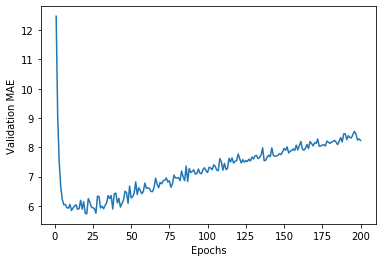

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


Zur besseren Ablesbarkeit kann die Kurve auch geglättet dargestellt werden.

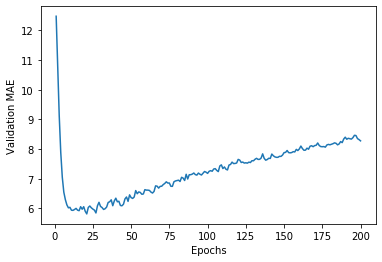

In [34]:
def smooth_curve(points, factor=0.5):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Das erste Modell erreicht bei 20 Epochen ein Minimum des mittleren absoluten Fehlers. Bei dieser Anzahl von Epochen geht das Modell von einer Unteranpassung in eine Überanpassung über. Deshalb wird das zweite Modell mit genau dieser Epochenanzahl trainiert. Damit erreicht das Modell den optimalen Lernerfolg, bei dem noch keine Überanpassung an die Trainingsdaten zu erwarten ist.

In [36]:
k = 4
num_val_samples = len(train_data) // k
num_epochs2 = 20
all_mae_histories2 = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = pd.concat(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_labels = pd.concat(
        [train_labels[:i * num_val_samples],
         train_labels[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model2 = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model2.fit(partial_train_data, partial_train_labels,
                        validation_data=(val_data, val_labels),
                        epochs=num_epochs2, batch_size=32, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories2.append(mae_history)

processing fold # 0
Train on 2526 samples, validate on 842 samples
Epoch 1/20
2526/2526 [==============================] - 1s 219us/step - loss: 4026.6003 - mae: 51.2201 - val_loss: 239.8442 - val_mae: 11.7413
Epoch 2/20
2526/2526 [==============================] - 0s 152us/step - loss: 184.5505 - mae: 9.7780 - val_loss: 136.4685 - val_mae: 8.6596
Epoch 3/20
2526/2526 [==============================] - 0s 152us/step - loss: 127.1021 - mae: 7.8169 - val_loss: 96.6990 - val_mae: 7.1072
Epoch 4/20
2526/2526 [==============================] - 0s 151us/step - loss: 106.2179 - mae: 6.9617 - val_loss: 79.6282 - val_mae: 6.2855
Epoch 5/20
2526/2526 [==============================] - 0s 173us/step - loss: 96.7283 - mae: 6.4590 - val_loss: 79.2983 - val_mae: 5.6663
Epoch 6/20
2526/2526 [==============================] - 0s 172us/step - loss: 91.5882 - mae: 6.1917 - val_loss: 71.1938 - val_mae: 5.4319
Epoch 7/20
2526/2526 [==============================] - 0s 148us/step - loss: 87.7367 - mae: 6.0

Zur Sicherheit wird dieses Modell zunächst abgespeichert.

In [37]:
 model2.save(r"C:\Users\johan\Desktop\MercedesBenzGreenerManufacturing\Model2.h5")

Auch für dieses Modell wird der Verlauf des Mittelwerts des mittleren absoluten Fehlers der Faltungsoperationen über den Epochen visualisiert.

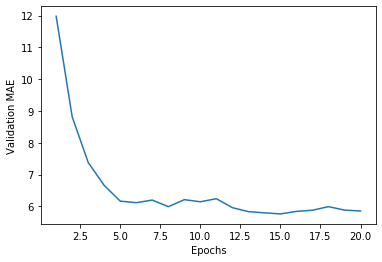

In [38]:
average_mae_history2 = [
    np.mean([x[i] for x in all_mae_histories2]) for i in range(num_epochs2)]
average_mae_history2
plt.plot(range(1, len(average_mae_history2) + 1), average_mae_history2)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Auch diese Kurve wird zur besseren Ablesbarkeit geglättet.

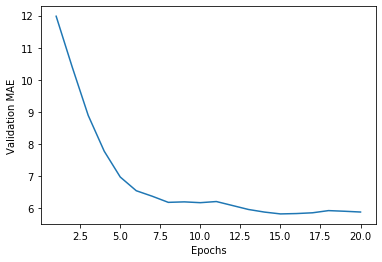

In [39]:
smooth_mae_history = smooth_curve(average_mae_history2[:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 5. Evaluation
In der Evaluationsphase wird das optimierte Modell mit den Testdaten überprüft. 
Dazu wird zunächst mit dem optimierten Modell eine Voraussage für die Testdaten erzeugt und in das DataFrame test geschrieben.

In [40]:
test=pd.DataFrame()
test=model2.predict(test_data)
test=pd.DataFrame(test, columns=['y_pred'])
test

,y_pred
0,94.589844
1,111.299507
2,92.968224
3,110.707802
4,93.228569
...,...
836,103.756165
837,100.636780
838,109.284416
839,91.459747


Weiterhin werden die Werte der tatsächlichen Prüfdauer in das Data-Frame test aufgenommen. 

In [41]:
y_true=test_labels.reset_index().drop(columns=['index'])
test['y_true']=y_true
test

,y_pred,y_true
0,94.589844,105.82
1,111.299507,108.19
2,92.968224,94.62
3,110.707802,110.46
4,93.228569,88.98
...,...,...
836,103.756165,107.39
837,100.636780,108.77
838,109.284416,109.22
839,91.459747,87.48


Durch Bildung des Absolutwertes der Differenz zwischen der vorhergesagten Prüfdauer y_pred und der tatsächlichen Prüfdauer y_true ergibt sich der absolute Vorhersagefehler absErr je Beobachtung. 

In [42]:
test['absErr']=abs(test.y_pred-test.y_true)
test

,y_pred,y_true,absErr
0,94.589844,105.82,11.230156
1,111.299507,108.19,3.109507
2,92.968224,94.62,1.651776
3,110.707802,110.46,0.247802
4,93.228569,88.98,4.248569
...,...,...,...
836,103.756165,107.39,3.633835
837,100.636780,108.77,8.133220
838,109.284416,109.22,0.064416
839,91.459747,87.48,3.979747


Der Mittelwert der Spalte absErr entspricht dem Mean Absolute Error der Vorhersage über alle Beobachtungen. In diesem Fall bedeutet dies, dass die Vorhersage im Mittel einen Fehler von 5 Minuten aufweist.

In [43]:
mae=test.absErr.mean()
mae

5.000412059516317

<b>Fazit:</b> <br> Durch die Verwendung eines neuronalen Netzes konnte der MAE um 50% gegenüber der ursprünglichen Voraussage 'Anwendung des Mittelwerts aller Prüfwerte' reduziert werden.

In [44]:
MAE_initial

y    10.088697
dtype: float64

Anschließend kann noch der R2-Score, das sogenannte Bestimmtheitsmaß, berechnet werden. Dieses war bei der Competition auf Kaggle.io als Bewertungskriterium für das Ranking ausschlaggebend. Dort erreichte das beste Modell einen R2-Score von 0,555. Zu beachten ist, dass im vorliegenden Beispiel ein Teil der Trainingsdaten als Testdaten verwendet wurden, weswegen das Ergebnis nicht direkt zu vergleichen ist mit den Angaben auf Kaggle.io.



In [45]:
def r2(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred)) 
    SS_tot = np.sum(np.square(y_true - np.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot) )
r2(test.y_true, test.y_pred)


0.6149867136956125

# 6. Einsatz

Nach der erfolgreichen Evaluation des Modells kann die Implementierung in den Fachbereich erfolgen. Vorstellbar wäre z.B. eine Applikation, welche anhand der zukünftig gebauten Fahrzeuge und deren Merkmalsausprägungen die Auslastung der Prüfstände voraussagt oder die Nutzung der vorausgesagten Prüfdauer für Preiskalkulationen. So könnte dem Kunden bereits bei der Modellkonfiguration die Prüfkosten angezeigt und in Rechnung gestellt werden.